# experiment

> @inproceedings{silva2020study, title={A study on tooth segmentation and numbering using end-to-end deep neural networks}, author={Silva, Bernardo and Pinheiro, Laís and Oliveira, Luciano and Pithon, Matheus} booktitle={Conference on Graphics, Patterns and Images (SIBGRAPI)}, year={2020}, organization={IEEE} }

### dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_PATH = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/folds'

IMG_PATH1 = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/folds/fold1/images'
IMG_PATH2 = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/folds/fold2/images'
IMG_PATH3 = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/folds/fold3/images'
IMG_PATH4 = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/folds/fold4/images'
IMG_TARGET = './drive/MyDrive/binary_masks/'

IMG_PATH5 = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/folds/fold5/images'
JSON_FILEPATH = './drive/MyDrive/dns-panoramic-images-ivisionlab/instance-segmentation/complete-json/dns-panoramic-images.json'

IMG_PATH_BINARY = './drive/MyDrive/dns-panoramic-images-ivisionlab/semantic-segmentation'
IMG_PATH6 = './drive/MyDrive/dns-panoramic-images-ivisionlab/semantic-segmentation/images'
IMG_PATH6_TARGET = './drive/MyDrive/dns-panoramic-images-ivisionlab/semantic-segmentation/masks'

In [ ]:
import json

json_file = open(JSON_FILEPATH, 'r')
json_data = json.load(json_file)

images = json_data['images']
annotations = json_data['annotations']

In [ ]:
import torch.utils.data as data
import os
import cv2
from skimage import io
import numpy as np
from conversions import annotations2mask, mask2instances
from PIL import Image

class Dataset(data.Dataset):
    def __init__(self, file_dir, transform_data=None, transform_labels=None, type='train'):
        self.transform_data,self.transform_labels=transform_data,transform_labels
        imgs = []
        labels = []
        for root, dirs, imgs_name in os.walk(file_dir):
          # only for semantic segmentation training, validation and test
          if type == 'train':
            if ((root == IMG_PATH1)|(root == IMG_PATH2)|(root == IMG_PATH3)|(root == IMG_PATH4)):
              for img in imgs_name:
                img_names = str(root)+'/'+ str(img)

                # read images:
                image = cv2.imread(img_names)
                # grayscale, convert to rgb for consistency
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                imgs.append(image)

                # read labels:
                sample_image_json = list(filter(lambda x: x['file_name'] == img, images))[0]
                sample_image_id = sample_image_json['id']
                # get the image annotations
                sample_annotations = [ann for ann in annotations if ann['image_id'] == sample_image_id]
                # get non-binary and binary mask
                height, width = sample_image_json['height'], sample_image_json['width']
                # teeth are white and background is black
                mask = annotations2mask(sample_annotations, height, width, binary=True)
                labels.append(mask)

          elif type == 'val':
            if (root == IMG_PATH5):
              for img in imgs_name:
                img_names = str(root)+'/'+ str(img)

                # read images:
                image = cv2.imread(img_names)
                # grayscale, convert to rgb for consistency
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                imgs.append(image)

                # read labels:
                sample_image_json = list(filter(lambda x: x['file_name'] == img, images))[0]
                sample_image_id = sample_image_json['id']
                # get the image annotations
                sample_annotations = [ann for ann in annotations if ann['image_id'] == sample_image_id]
                # get non-binary and binary mask
                height, width = sample_image_json['height'], sample_image_json['width']
                # teeth are white and background is black
                mask = annotations2mask(sample_annotations, height, width, binary=True)
                labels.append(mask)


        imgs = np.array(imgs)
        labels = np.array(labels)
        self.labels=labels
        self.data=imgs

    def __getitem__(self, index):
        img, target = self.data[index], self.labels[index]
        if self.transform_data:
            img = Image.fromarray(img)
            img=self.transform_data(img)
        if self.transform_labels:
            target = Image.fromarray(target)
            target=self.transform_labels(target)
        return img, target

    def __len__(self):
        return len(self.data)



### dataloader

> 256

In [ ]:
from torchvision import transforms
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize
import torch.nn.functional as F



def get_data(batch_size, type, data_root=IMG_PATH):
    data_loader = data.DataLoader(
        Dataset(
            file_dir=data_root,
            transform_data=transforms.Compose([
                Resize((256,256)),
                ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                
            ]),
            transform_labels=transforms.Compose([
                Resize((256,256)),
                ToTensor(),
    
            ]),
            type=type
        ),
        batch_size=batch_size,
        shuffle=True,
        num_workers=1
    )
    return data_loader



## training teacher network

all models should be in model.py

### segcap model definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import nn_
import torch.optim as optim

class CapsuleLayer(nn.Module):
    def __init__(self, t_0,z_0, op, k, s, t_1, z_1, routing):
        super().__init__()
        self.t_1 = t_1
        self.z_1 = z_1
        self.op = op
        self.k = k
        self.s = s
        self.routing = routing
        self.convs = nn.ModuleList()
        self.t_0=t_0
        for _ in range(t_0):
            if self.op=='conv':
                self.convs.append(nn.Conv2d(z_0, self.t_1*self.z_1, self.k, self.s,padding=2,bias=False))
            else:
                self.convs.append(nn.ConvTranspose2d(z_0, self.t_1 * self.z_1, self.k, self.s,padding=2,output_padding=1))

    def forward(self, u):  # input [N,CAPS,C,H,W]
        if u.shape[1]!=self.t_0:
            raise ValueError("Wrong type of operation for capsule")
        op = self.op
        k = self.k
        s = self.s
        t_1 = self.t_1
        z_1 = self.z_1
        routing = self.routing
        N = u.shape[0]
        H_1=u.shape[3]
        W_1=u.shape[4]
        t_0 = self.t_0

        u_t_list = [u_t.squeeze(1) for u_t in u.split(1, 1)]

        u_hat_t_list = []

        for i, u_t in zip(range(self.t_0), u_t_list):  # u_t: [N,C,H,W]
            if op == "conv":
                u_hat_t = self.convs[i](u_t)
            elif op == "deconv":
                u_hat_t = self.convs[i](u_t) #u_hat_t: [N,t_1*z_1,H,W]
            else:
                raise ValueError("Wrong type of operation for capsule")
            H_1 = u_hat_t.shape[2]
            W_1 = u_hat_t.shape[3]
            u_hat_t = u_hat_t.reshape(N, t_1,z_1,H_1, W_1).transpose_(1,3).transpose_(2,4)
            u_hat_t_list.append(u_hat_t)    #[N,H_1,W_1,t_1,z_1]
        v=self.update_routing(u_hat_t_list,k,N,H_1,W_1,t_0,t_1,routing)
        return v
    def update_routing(self,u_hat_t_list, k, N, H_1, W_1, t_0, t_1, routing):
        one_kernel = torch.ones(1, t_1, k, k).cuda()
        b = torch.zeros(N, H_1, W_1, t_0, t_1).cuda()
        b_t_list = [b_t.squeeze(3) for b_t in b.split(1, 3)]
        u_hat_t_list_sg = []
        for u_hat_t in u_hat_t_list:
            u_hat_t_sg=u_hat_t.detach()
            u_hat_t_list_sg.append(u_hat_t_sg)

        for d in range(routing):
            if d < routing - 1:
                u_hat_t_list_ = u_hat_t_list_sg
            else:
                u_hat_t_list_ = u_hat_t_list

            r_t_mul_u_hat_t_list = []
            for b_t, u_hat_t in zip(b_t_list, u_hat_t_list_):
                # routing softmax (N,H_1,W_1,t_1)
                b_t.transpose_(1, 3).transpose_(2, 3)  #[N,t_1,H_1, W_1]
                b_t_max = torch.nn.functional.max_pool2d(b_t,k,1,padding=2)
                b_t_max = b_t_max.max(1, True)[0]
                c_t = torch.exp(b_t - b_t_max)
                sum_c_t = nn_.conv2d_same(c_t, one_kernel, stride=(1, 1))  # [... , 1]
                r_t = c_t / sum_c_t  # [N,t_1, H_1, W_1]
                r_t = r_t.transpose(1, 3).transpose(1, 2)  # [N, H_1, W_1,t_1]
                r_t = r_t.unsqueeze(4)  # [N, H_1, W_1,t_1, 1]
                r_t_mul_u_hat_t_list.append(r_t * u_hat_t)  # [N, H_1, W_1, t_1, z_1]
            p = sum(r_t_mul_u_hat_t_list)  # [N, H_1, W_1, t_1, z_1]
            v = self.squash(p)
            if d < routing - 1:
                b_t_list_ = []
                for b_t, u_hat_t in zip(b_t_list, u_hat_t_list_):
                    # b_t     : [N, t_1,H_1, W_1]
                    # u_hat_t : [N, H_1, W_1, t_1, z_1]
                    # v       : [N, H_1, W_1, t_1, z_1]
                    # [N,H_1,W_1,t_1]
                    b_t.transpose_(1,3).transpose_(2,1)
                    b_t_list_.append(b_t + (u_hat_t * v).sum(4))
        v.transpose_(1, 3).transpose_(2, 4)
        # print(v.grad)
        return v
    def squash(self, p):
        p_norm_sq = (p * p).sum(-1, True)
        p_norm = (p_norm_sq + 1e-9).sqrt()
        v = p_norm_sq / (1. + p_norm_sq) * p / p_norm
        return v

In [ ]:
import torch
import torch.nn as nn
import nn_

# default n_class=2(1)

class SegCaps(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(3, 16, 5, 1, padding=2,bias=False),

        )
        self.step_1 = nn.Sequential(  # 1/2
            CapsuleLayer(1, 16, "conv", k=5, s=2, t_1=2, z_1=16, routing=1),
            CapsuleLayer(2, 16, "conv", k=5, s=1, t_1=4, z_1=16, routing=3),
        )
        self.step_2 = nn.Sequential(  # 1/4
            CapsuleLayer(4, 16, "conv", k=5, s=2, t_1=4, z_1=32, routing=3),
            CapsuleLayer(4, 32, "conv", k=5, s=1, t_1=8, z_1=32, routing=3)
        )
        self.step_3 = nn.Sequential(  # 1/8
            CapsuleLayer(8, 32, "conv", k=5, s=2, t_1=8, z_1=64, routing=3),
            CapsuleLayer(8, 64, "conv", k=5, s=1, t_1=8, z_1=32, routing=3)
        )
        self.step_4 = CapsuleLayer(8, 32, "deconv", k=5, s=2, t_1=8, z_1=32, routing=3)

        self.step_5 = CapsuleLayer(16, 32, "conv", k=5, s=1, t_1=4, z_1=32, routing=3)

        self.step_6 = CapsuleLayer(4, 32, "deconv", k=5, s=2, t_1=4, z_1=16, routing=3)
        self.step_7 = CapsuleLayer(8, 16, "conv", k=5, s=1, t_1=4, z_1=16, routing=3)
        self.step_8 = CapsuleLayer(4, 16, "deconv", k=5, s=2, t_1=2, z_1=16, routing=3)
        self.step_10 = CapsuleLayer(3, 16, "conv", k=5, s=1, t_1=1, z_1=16, routing=3)
        self.conv_2 = nn.Sequential(
            nn.Conv2d(16, 1, 5, 1, padding=2),
        )
    def forward(self, x):
        # out = {}

        x = self.conv_1(x)
        x.unsqueeze_(1)

        skip_1 = x  # [N,1,16,H,W]

        x = self.step_1(x)

        skip_2 = x  # [N,4,16,H/2,W/2]
        x = self.step_2(x)

        skip_3 = x  # [N,8,32,H/4,W/4]

        x = self.step_3(x)  # [N,8,32,H/8,W/8]


        x = self.step_4(x)  # [N,8,32,H/4,W/4]
        x = torch.cat((x, skip_3), 1)  # [N,16,32,H/4,W/4]

        x = self.step_5(x)  # [N,4,32,H/4,W/4]

        x = self.step_6(x)  # [N,4,16,H/2,W/2]

        x = torch.cat((x, skip_2), 1)   # [N,8,16,H/2,W/2]
        x = self.step_7(x)  # [N,4,16,H/2,W/2]
        x = self.step_8(x)  # [N,2,16,H,W]

        x=torch.cat((x,skip_1),1)
        x=self.step_10(x)

        ######
        x.squeeze_(1)
        # x.shape
        v_lens = self.compute_vector_length(x)
        # v_lens.shape

        # note it for using loss function of torch
        # v_lens=v_lens.squeeze(1)
        # v_lens.shape
        


        # out['seg_output'] = v_lens
        # out['pre'] = x

        return v_lens
    def compute_vector_length(self, x):
        out = (x.pow(2)).sum(1, True)+1e-9
        out=out.sqrt()
        return out

In [ ]:
from torchsummary import summary

model = SegCaps()

model.cuda()

summary(model, input_size=[(3, 256, 256)], batch_size=8, device="cuda")

# 与原结构的差异在 缺失最后一层胶囊层之后（见截图
# 输出层不应是胶囊层  : 需要做实验

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 16, 256, 256]           1,200
            Conv2d-2          [8, 32, 128, 128]          12,800
      CapsuleLayer-3       [8, 2, 16, 128, 128]               0
            Conv2d-4          [8, 64, 128, 128]          25,600
            Conv2d-5          [8, 64, 128, 128]          25,600
      CapsuleLayer-6       [8, 4, 16, 128, 128]               0
            Conv2d-7           [8, 128, 64, 64]          51,200
            Conv2d-8           [8, 128, 64, 64]          51,200
            Conv2d-9           [8, 128, 64, 64]          51,200
           Conv2d-10           [8, 128, 64, 64]          51,200
     CapsuleLayer-11         [8, 4, 32, 64, 64]               0
           Conv2d-12           [8, 256, 64, 64]         204,800
           Conv2d-13           [8, 256, 64, 64]         204,800
           Conv2d-14           [8, 256,

### Unet

In [ ]:
# unet 
import torch.nn as nn
import torch
from torch import autograd
from functools import partial
import torch.nn.functional as F
from torchvision import models

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class UNet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UNet, self).__init__()

        self.conv1 = DoubleConv(in_ch, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(128, 256)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(256, 512)
        self.up6 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv6 = DoubleConv(512, 256)
        self.up7 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv7 = DoubleConv(256, 128)
        self.up8 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv8 = DoubleConv(128, 64)
        self.up9 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv9 = DoubleConv(64, 32)
        self.conv10 = nn.Conv2d(32, out_ch, 1)

    def forward(self, x):
        out={}
        #print(x.shape)
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        #print(p1.shape)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        #print(p2.shape)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        #print(p3.shape)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        #print(p4.shape)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        out['final'] = nn.Sigmoid()(c10)
        out['logits'] = c10
        out['feas'] = c9

        return out

In [ ]:
from torchsummary import summary

# n_channels=3, n_classes=1  means 2 classes
model = UNet(3,1)

model.cuda()

summary(model, input_size=[(3, 512, 512)], batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 32, 512, 512]             896
       BatchNorm2d-2          [1, 32, 512, 512]              64
              ReLU-3          [1, 32, 512, 512]               0
            Conv2d-4          [1, 32, 512, 512]           9,248
       BatchNorm2d-5          [1, 32, 512, 512]              64
              ReLU-6          [1, 32, 512, 512]               0
        DoubleConv-7          [1, 32, 512, 512]               0
         MaxPool2d-8          [1, 32, 256, 256]               0
            Conv2d-9          [1, 64, 256, 256]          18,496
      BatchNorm2d-10          [1, 64, 256, 256]             128
             ReLU-11          [1, 64, 256, 256]               0
           Conv2d-12          [1, 64, 256, 256]          36,928
      BatchNorm2d-13          [1, 64, 256, 256]             128
             ReLU-14          [1, 64, 2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Unet++

In [ ]:
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class NestedUNet(nn.Module):
    def __init__(self, deepsupervision,in_channel,out_channel):
        super().__init__()

        self.deepsupervision = deepsupervision

        nb_filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = DoubleConv(in_channel, nb_filter[0])
        self.conv1_0 = DoubleConv(nb_filter[0], nb_filter[1])
        self.conv2_0 = DoubleConv(nb_filter[1], nb_filter[2])
        self.conv3_0 = DoubleConv(nb_filter[2], nb_filter[3])
        self.conv4_0 = DoubleConv(nb_filter[3], nb_filter[4])

        self.conv0_1 = DoubleConv(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = DoubleConv(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = DoubleConv(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = DoubleConv(nb_filter[3]+nb_filter[4], nb_filter[3])

        self.conv0_2 = DoubleConv(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = DoubleConv(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = DoubleConv(nb_filter[2]*2+nb_filter[3], nb_filter[2])

        self.conv0_3 = DoubleConv(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = DoubleConv(nb_filter[1]*3+nb_filter[2], nb_filter[1])

        self.conv0_4 = DoubleConv(nb_filter[0]*4+nb_filter[1], nb_filter[0])
        self.sigmoid = nn.Sigmoid()
        if self.deepsupervision:
            self.final1 = nn.Conv2d(nb_filter[0], out_channel, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], out_channel, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], out_channel, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], out_channel, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], out_channel, kernel_size=1)


    def forward(self, input):
        output = {}
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deepsupervision:
            output1 = self.final1(x0_1)
            output1 = self.sigmoid(output1)
            output2 = self.final2(x0_2)
            output2 = self.sigmoid(output2)
            output3 = self.final3(x0_3)
            output3 = self.sigmoid(output3)
            output4 = self.final4(x0_4)
            output4 = self.sigmoid(output4)
            return [output1, output2, output3, output4]

        else:
            output['logits'] = self.final(x0_4)
            output['final'] = self.sigmoid(self.final(x0_4))
            output['feas'] = x0_4
            return output

In [ ]:
from torchsummary import summary

# n_channels=3, n_classes=1  means 2 classes
model = NestedUNet(0,in_channel=3,out_channel=1)

model.cuda()

summary(model, input_size=[(3, 512, 512)], batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 32, 512, 512]             896
       BatchNorm2d-2          [1, 32, 512, 512]              64
              ReLU-3          [1, 32, 512, 512]               0
            Conv2d-4          [1, 32, 512, 512]           9,248
       BatchNorm2d-5          [1, 32, 512, 512]              64
              ReLU-6          [1, 32, 512, 512]               0
        DoubleConv-7          [1, 32, 512, 512]               0
         MaxPool2d-8          [1, 32, 256, 256]               0
            Conv2d-9          [1, 64, 256, 256]          18,496
      BatchNorm2d-10          [1, 64, 256, 256]             128
             ReLU-11          [1, 64, 256, 256]               0
           Conv2d-12          [1, 64, 256, 256]          36,928
      BatchNorm2d-13          [1, 64, 256, 256]             128
             ReLU-14          [1, 64, 2

### R2U_Net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x
class Recurrent_block(nn.Module):
    def __init__(self, ch_out, t=2):
        super(Recurrent_block, self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        for i in range(self.t):

            if i == 0:
                x1 = self.conv(x)

            x1 = self.conv(x + x1)
        return x1

class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1
class R2U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=1, t=2):
        super(R2U_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch, ch_out=64, t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64, ch_out=128, t=t)

        self.RRCNN3 = RRCNN_block(ch_in=128, ch_out=256, t=t)

        self.RRCNN4 = RRCNN_block(ch_in=256, ch_out=512, t=t)

        self.RRCNN5 = RRCNN_block(ch_in=512, ch_out=1024, t=t)

        self.Up5 = up_conv(ch_in=1024, ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512, t=t)

        self.Up4 = up_conv(ch_in=512, ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256, t=t)

        self.Up3 = up_conv(ch_in=256, ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128, t=t)

        self.Up2 = up_conv(ch_in=128, ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64, t=t)

        self.Conv_1x1 = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = {}
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)
        out['final'] = self.sigmoid(d1)
        out['logits'] = d1
        out['feas'] = d2
        return out

In [ ]:
from torchsummary import summary

# n_channels=3, n_classes=1  means 2 classes
model = R2U_Net()

model.cuda()

summary(model, input_size=[(3, 512, 512)], batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 512, 512]             256
            Conv2d-2          [1, 64, 512, 512]          36,928
       BatchNorm2d-3          [1, 64, 512, 512]             128
              ReLU-4          [1, 64, 512, 512]               0
            Conv2d-5          [1, 64, 512, 512]          36,928
       BatchNorm2d-6          [1, 64, 512, 512]             128
              ReLU-7          [1, 64, 512, 512]               0
            Conv2d-8          [1, 64, 512, 512]          36,928
       BatchNorm2d-9          [1, 64, 512, 512]             128
             ReLU-10          [1, 64, 512, 512]               0
  Recurrent_block-11          [1, 64, 512, 512]               0
           Conv2d-12          [1, 64, 512, 512]          36,928
      BatchNorm2d-13          [1, 64, 512, 512]             128
             ReLU-14          [1, 64, 5

### unet_16

In [ ]:
# student network architecture
# reference: Distilling the Knowledge in a Neural Network - Geoffrey Hinton, Oriol Vinyals, Jeff Dean

# Structured Knowledge Distillation for Dense Prediction - Yifan Liu, Changyong Shun, Jingdong Wang, Chunhua Shen

# On Compressing U-net Using Knowledge Distillation - Karttikeya Mangalam, Mathieu Salzamann


import torch.nn as nn
import torch
from torch import autograd
from functools import partial
import torch.nn.functional as F
from torchvision import models

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class UNet_16(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UNet_16, self).__init__()

        self.conv1 = DoubleConv(in_ch, 16)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(16, 32)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(32, 64)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(64, 128)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(128, 256)
        self.up6 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv6 = DoubleConv(256, 128)
        self.up7 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv7 = DoubleConv(128, 64)
        self.up8 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv8 = DoubleConv(64, 32)
        self.up9 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv9 = DoubleConv(32, 16)
        self.conv10 = nn.Conv2d(16, out_ch, 1)

    def forward(self, x):
        out={}
        #print(x.shape)
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        #print(p1.shape)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        #print(p2.shape)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        #print(p3.shape)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        #print(p4.shape)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        out['final'] = nn.Sigmoid()(c10)
        out['logits'] = c10
        out['feas'] = c9

        return out

### train function

In [ ]:
# metrics.py


# batch_size should be set as 1

import cv2
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import matplotlib.pyplot as plt
from skimage.io import imread
import imageio


def get_iou(mask,predict):
    # image_mask = cv2.imread(mask_name,0)
    # if np.all(image_mask == None):
    #     image_mask = imageio.mimread(mask_name)
    #     image_mask = np.array(image_mask)[0]
    #     image_mask = cv2.resize(image_mask,(576,576))
    
    # print(image.shape)
    
    image_mask = torch.squeeze(mask).cpu().numpy()
    height = predict.shape[0]
    weight = predict.shape[1]
    # print(height*weight)
    o = 0
    for row in range(height):
            for col in range(weight):
                if predict[row, col] < 0.5:
                    predict[row, col] = 0
                else:
                    predict[row, col] = 1
                if predict[row, col] == 0 or predict[row, col] == 1:
                    o += 1

    predict = predict.astype(np.int16)

    interArea = np.multiply(predict, image_mask)
    tem = predict + image_mask
    unionArea = tem - interArea
    inter = np.sum(interArea)
    union = np.sum(unionArea)
    iou_tem = inter / union

    # print('%s:iou=%f' % ("iou",iou_tem))

    return iou_tem

def get_dice(mask,predict):
    # image_mask = cv2.imread(mask_name, 0)
    # if np.all(image_mask == None):
    #     image_mask = imageio.mimread(mask_name)
    #     image_mask = np.array(image_mask)[0]
    #     image_mask = cv2.resize(image_mask,(576,576))
    
    image_mask = torch.squeeze(mask).cpu().numpy()
    height = predict.shape[0]
    weight = predict.shape[1]
    o = 0
    for row in range(height):
        for col in range(weight):
            if predict[row, col] < 0.5:
                predict[row, col] = 0
            else:
                predict[row, col] = 1
            if predict[row, col] == 0 or predict[row, col] == 1:
                o += 1
    predict = predict.astype(np.int16)
    intersection = (predict*image_mask).sum()
    dice = (2. *intersection) /(predict.sum()+image_mask.sum())
    return dice

def get_hd(mask,predict):
    # image_mask = cv2.imread(mask_name, 0)
    # # print(mask_name)
    # # print(image_mask)
    # if np.all(image_mask == None):
    #     image_mask = imageio.mimread(mask_name)
    #     image_mask = np.array(image_mask)[0]
    #     image_mask = cv2.resize(image_mask,(576,576))
    # print(mask.shape)
    # print(mask)
    image_mask = torch.squeeze(mask).cpu().numpy()
    # print(mask.shape)
    # print("####################")
    # print(predict.shape)
    # print(predict)
    

    height = predict.shape[0]
    weight = predict.shape[1]
    o = 0

    
    for row in range(height):
        for col in range(weight):
            if predict[row, col] < 0.5:
                predict[row, col] = 0
            else:
                predict[row, col] = 1
            if predict[row, col] == 0 or predict[row, col] == 1:
                o += 1

    hd1 = directed_hausdorff(image_mask, predict)[0]
    hd2 = directed_hausdorff(predict, image_mask)[0]
    res = None
    if hd1>hd2 or hd1 == hd2:
        res=hd1
        return res
    else:
        res=hd2
        return res



def show(predict):
    height = predict.shape[0]
    weight = predict.shape[1]
    for row in range(height):
        for col in range(weight):
            predict[row, col] *= 255
    plt.imshow(predict)
    plt.show()

In [ ]:
# plot.py
  
import matplotlib.pyplot as plt
import os
def loss_plot(args,loss):
    num = args.epoch
    x = [i for i in range(num)]
    plot_save_path = r'result/plot/'
    if not os.path.exists(plot_save_path):
        os.makedirs(plot_save_path)
    save_loss = plot_save_path+'_'+str(args.batch_size)+'_'+str(args.epoch)+'_loss.jpg'
    plt.figure()
    plt.plot(x,loss,label='loss')
    plt.legend()
    plt.savefig(save_loss)

def metrics_plot(arg,name,*args):
    num = arg.epoch
    names = name.split('&')
    metrics_value = args
    i=0
    x = [i for i in range(num)]
    plot_save_path = r'result/plot/'
    if not os.path.exists(plot_save_path):
        os.makedirs(plot_save_path)
    save_metrics = plot_save_path  + '_' + str(arg.batch_size) + '_'  + str(arg.epoch) + '_'+name+'.jpg'
    plt.figure()
    for l in metrics_value:
        plt.plot(x,l,label=str(names[i]))
        #plt.scatter(x,l,label=str(l))
        i+=1
    plt.legend()
    plt.savefig(save_metrics)

In [ ]:
import argparse
import os
import logging
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import autograd, optim

from torchvision.transforms import transforms


def getArgs():
    parse = argparse.ArgumentParser()
    parse.add_argument('--deepsupervision', default=0)
    # parse.add_argument("--action", type=str, help="train/test/train&test", default="train&test")
    parse.add_argument("--epoch", type=int, default=31)
    # parse.add_argument('--arch', '-a', metavar='ARCH', default='resnet34_unet',
    #                    help='UNet/resnet34_unet/unet++/myChannelUnet/Attention_UNet/segnet/r2unet/fcn32s/fcn8s')
    # batch_size have to be 1
    parse.add_argument("--batch_size", type=int, default=1)
    # parse.add_argument('--dataset', default='driveEye',  # dsb2018_256
    #                    help='dataset name:liver/esophagus/dsb2018Cell/corneal/driveEye/isbiCell/kaggleLung')
    # parse.add_argument("--ckp", type=str, help="the path of model weight file")
    parse.add_argument("--learning_rate",type=float,default=1e-3)
    parse.add_argument("--log_dir", default='result/log', help="log dir")
    parse.add_argument("--threshold",type=float,default=None)
    parse.add_argument("-f", help="a dummy argument to fool ipython", default="1")
    args = parse.parse_args()
    return args

def getLog(arg):
    # "arg" should be a input value of this function
    dirname = os.path.join(arg.log_dir,str(arg.batch_size),str(arg.epoch))
    filename = dirname +'/log.log'
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    logging.basicConfig(
            filename=filename,
            level=logging.DEBUG,
            format='%(asctime)s:%(levelname)s:%(message)s'
        )
    return logging

def val(model,best_iou,val_dataloaders):
    model= model.eval()
    with torch.no_grad():
        i=0
        miou_total = 0
        hd_total = 0
        dice_total = 0
        num = len(val_dataloaders)
        #print(num)
        # batch_index,(data,target)
        # x, _,pic,mask
        for data,target in val_dataloaders:
            data = data.to(device)
            ##
            # for others
            # y = model(data)['final']
            # for segcap
            y = model(data)

            if args.deepsupervision:
                img_y = torch.squeeze(y[-1]).cpu().numpy()
            else:
                img_y = torch.squeeze(y).cpu().numpy()

            hd_total += get_hd(target, img_y)
            miou_total += get_iou(target,img_y)
            dice_total += get_dice(target,img_y)
            if i < num:i+=1
        aver_iou = miou_total / num
        aver_hd = hd_total / num
        aver_dice = dice_total/num
        print('Miou=%f,aver_hd=%f,aver_dice=%f' % (aver_iou,aver_hd,aver_dice))
        logging.info('Miou=%f,aver_hd=%f,aver_dice=%f' % (aver_iou,aver_hd,aver_dice))
        if aver_iou > best_iou:
            print('aver_iou:{} > best_iou:{}'.format(aver_iou,best_iou))
            logging.info('aver_iou:{} > best_iou:{}'.format(aver_iou,best_iou))
            logging.info('===========>save best model!')
            best_iou = aver_iou
            print('===========>save best model!')
            if not os.path.exists('./saved_model'):
                os.makedirs('./saved_model')
            torch.save(model.state_dict(), r'./saved_model/'+'_'+str(args.batch_size)+'_'+str(args.epoch)+'.pth')
        return best_iou,aver_iou,aver_dice,aver_hd

def train(model, criterion, optimizer, train_dataloader,val_dataloader, args):
    best_iou,aver_iou,aver_dice,aver_hd = 0,0,0,0
    num_epochs = args.epoch
    threshold = args.threshold
    loss_list = []
    iou_list = []
    dice_list = []
    hd_list = []
    for epoch in range(num_epochs):
        model = model.train()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        logging.info('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(train_dataloader.dataset)
        epoch_loss = 0
        step = 0
        for x, y in train_dataloader:
            step += 1
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            if args.deepsupervision:
                ##
                outputs = model(inputs)['final']
                # outputs = model(inputs)

                loss = 0
                
                # print(output)
                # print(output.shape)
                # print(labels)
                # print(labels.shape)

                for output in outputs:
                    loss += criterion(output, labels)
                loss /= len(outputs)
            else:
                output = model(inputs)['final']
                # output = model(inputs)
                # print(output)
                # print(output.shape)
                # print(labels)
                # print(labels.shape)
                
                loss = criterion(output, labels)
            if threshold!=None:
                if loss > threshold:
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
            else:
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // train_dataloader.batch_size + 1, loss.item()))
            logging.info("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // train_dataloader.batch_size + 1, loss.item()))
        loss_list.append(epoch_loss)

        best_iou,aver_iou,aver_dice,aver_hd = val(model,best_iou,val_dataloader)
        iou_list.append(aver_iou)
        dice_list.append(aver_dice)
        hd_list.append(aver_hd)
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss))
        logging.info("epoch %d loss:%0.3f" % (epoch, epoch_loss))
    loss_plot(args, loss_list)
    metrics_plot(args, 'iou&dice',iou_list, dice_list)
    metrics_plot(args,'hd',hd_list)




In [ ]:
# parameters should be set in args
args = getArgs()
logging = getLog(args)


train_loader = get_data(batch_size=args.batch_size, type='train')
val_loader = get_data(batch_size=args.batch_size, type='val')

流式输出内容被截断，只能显示最后 5000 行内容。
235/432,train_loss:0.331
236/432,train_loss:0.307
237/432,train_loss:0.364
238/432,train_loss:0.425
239/432,train_loss:0.332
240/432,train_loss:0.331
241/432,train_loss:0.376
242/432,train_loss:0.331
243/432,train_loss:0.365
244/432,train_loss:0.317
245/432,train_loss:0.391
246/432,train_loss:0.364
247/432,train_loss:0.299
248/432,train_loss:0.334
249/432,train_loss:0.386
250/432,train_loss:0.194
251/432,train_loss:0.370
252/432,train_loss:0.371
253/432,train_loss:0.349
254/432,train_loss:0.329
255/432,train_loss:0.416
256/432,train_loss:0.341
257/432,train_loss:0.366
258/432,train_loss:0.376
259/432,train_loss:0.382
260/432,train_loss:0.372
261/432,train_loss:0.407
262/432,train_loss:0.384
263/432,train_loss:0.390
264/432,train_loss:0.385
265/432,train_loss:0.366
266/432,train_loss:0.386
267/432,train_loss:0.317
268/432,train_loss:0.367
269/432,train_loss:0.365
270/432,train_loss:0.375
271/432,train_loss:0.450
272/432,train_loss:0.362
273/432,train_loss:0.35

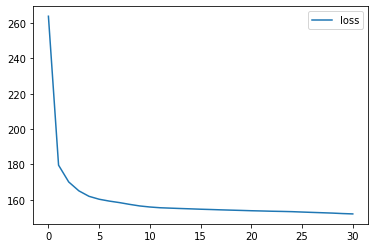

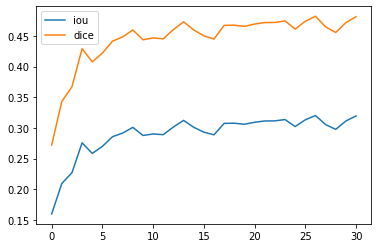

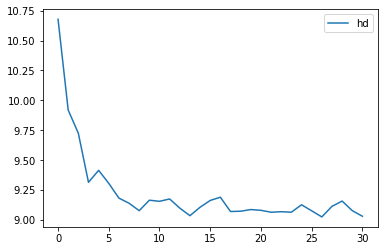

In [ ]:

# args = getArgs()
# logging = getLog(args)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('**************************')
print('\nepoch:%s,\nbatch size:%s\n' % \
      (args.epoch, args.batch_size))
logging.info('\n=======\n\nepoch:%s,\nbatch size:%s\n========' % \
      (args.epoch, args.batch_size))
print('**************************')


# model = NestedUNet(0,in_channel=3,out_channel=1)
# model = R2U_Net()
# model = UNet_16(3,1)
model = SegCaps()

model.cuda()

criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
train(model, criterion, optimizer, train_loader, val_loader, args)

In [ ]:
# test models

def test(val_dataloaders,save_predict=False):
    logging.info('final test........')
    if save_predict ==True:
        dir = os.path.join(r'./saved_predict',str(args.batch_size),str(args.epoch))
        if not os.path.exists(dir):
            os.makedirs(dir)
        else:
            print('dir already exist!')
    model.eval()

    #plt.ion()
    with torch.no_grad():
        i=0
        miou_total = 0
        hd_total = 0
        dice_total = 0
        std_d = []
        num = len(val_dataloaders)
        # for pic,_,pic_path,mask_path in val_dataloaders:
        for data,target in val_dataloaders:
            data = data.to(device)
            predict = model(data)['final']
            # predict = model(data)
            if args.deepsupervision:
                predict = torch.squeeze(predict[-1]).cpu().numpy()
            else:
                predict = torch.squeeze(predict).cpu().numpy()  
            #img_y = torch.squeeze(y).cpu().numpy()  

            iou = get_iou(target,predict)
            miou_total += iou
            hd_total += get_hd(target, predict)
            dice = get_dice(target,predict)
            # std_d is for computing std of dice
            std_d.append(dice)

            dice_total += dice

            # print(target.shape)
            fig = plt.figure()
            ax1 = fig.add_subplot(1, 3, 1)
            ax1.set_title('input')
            # show input
            ori_img = data.cpu()
            # print(ori_img.shape)
            # revise shape from (3,512,512) to (512,512,3) for imshow()
            img1_channel1=ori_img.numpy()[0,:,:,:][0,:,:][:,:,None]#array(512, 512, 1)
            img1_channel2=ori_img.numpy()[0,:,:,:][1,:,:][:,:,None]#array(512, 512, 1)
            img1_channel3=ori_img.numpy()[0,:,:,:][2,:,:][:,:,None]#array(512, 512, 1)

            ori_img=np.concatenate((img1_channel1,img1_channel2,img1_channel3),axis=-1)

            plt.imshow(ori_img)

            #print(pic_path[0])
            ax2 = fig.add_subplot(1, 3, 2)
            ax2.set_title('predict')
            plt.imshow(predict,cmap='Greys_r')

            ax3 = fig.add_subplot(1, 3, 3)
            ax3.set_title('mask')
            # show target
            plt.imshow(target[0][0], cmap='Greys_r')

            #print(mask_path[0])
            if save_predict == True:
                  plt.savefig(dir +'/'+ str(i)+ '.jpg')
            #plt.pause(0.01)
            print('iou={},dice={}'.format(iou,dice))
            if i < num:i+=1
        #plt.show()
        print('Miou=%f,aver_hd=%f,dv=%f,std_dice=%f' % (miou_total/num,hd_total/num,dice_total/num, np.std(std_d)))
        logging.info('Miou=%f,aver_hd=%f,dv=%f,std_dice=%f' % (miou_total/num,hd_total/num,dice_total/num, np.std(std_d)))
        #print('M_dice=%f' % (dice_total / num))

In [ ]:
!pip install thop

In [ ]:
# parameters should be set in args
args = getArgs()
logging = getLog(args)

val_loader = get_data(batch_size=args.batch_size, type='val')

iou=0.3297877907752991,dice=0.49600067286451666
iou=0.29350751638412476,dice=0.45381649855156814
iou=0.4398776888847351,dice=0.6109931968875439
iou=0.19308701157569885,dice=0.32367633528975776
iou=0.2935933768749237,dice=0.4539190850560779
iou=0.36205029487609863,dice=0.5316254278974607
iou=0.3570951223373413,dice=0.5262639518096887
iou=0.2628215551376343,dice=0.4162449912174139
iou=0.2784748077392578,dice=0.4356359354291217
iou=0.34370148181915283,dice=0.5115741771043298
iou=0.35033348202705383,dice=0.5188843901129767
iou=0.34142038226127625,dice=0.5090430768968901
iou=0.2689502239227295,dice=0.4238940010607212
iou=0.26120278239250183,dice=0.4142121890320724
iou=0.4596032202243805,dice=0.6297646056024802
iou=0.2687184810638428,dice=0.423606191212567
iou=0.41123175621032715,dice=0.5827983477801543
iou=0.40438857674598694,dice=0.5758926780008953
iou=0.33247268199920654,dice=0.49903111443391673
iou=0.3222440183162689,dice=0.48741984475595634


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


iou=0.30976369976997375,dice=0.47300696349675453
iou=0.33220213651657104,dice=0.498726335002489
iou=0.3455643653869629,dice=0.5136348566896484
iou=0.3123666048049927,dice=0.47603556233932903
iou=0.3494492471218109,dice=0.5179139008410992
iou=0.27550747990608215,dice=0.43199667300915345
iou=0.28758689761161804,dice=0.44670679389774065
iou=0.33842673897743225,dice=0.505708238923531
iou=0.3516101837158203,dice=0.5202834191016114
iou=0.3363193869590759,dice=0.5033518606936686
iou=0.35100582242012024,dice=0.5196214406660603
iou=0.2768746614456177,dice=0.43367558387545935
iou=0.26105019450187683,dice=0.4140203404063416
iou=0.3363857865333557,dice=0.5034261905463525
iou=0.22904802858829498,dice=0.3727243140201419
iou=0.30883243680000305,dice=0.47192050635106464
iou=0.23874370753765106,dice=0.3854610453170344
iou=0.23911212384700775,dice=0.3859410502585031
iou=0.3384907841682434,dice=0.5057797275847716
iou=0.301128625869751,dice=0.4628729514669408
iou=0.32623082399368286,dice=0.491966870097825

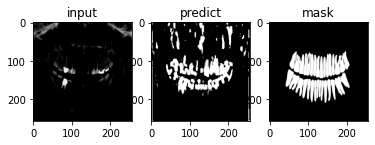

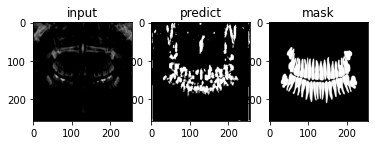

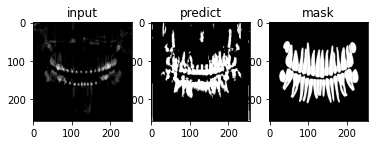

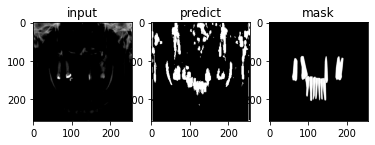

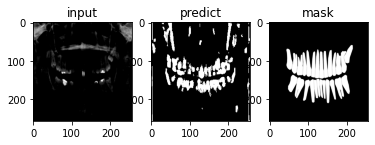

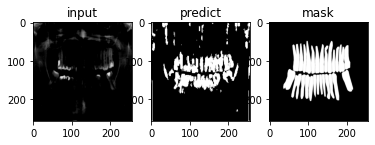

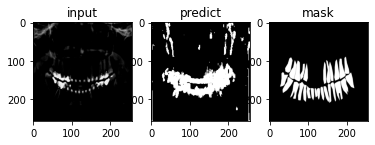

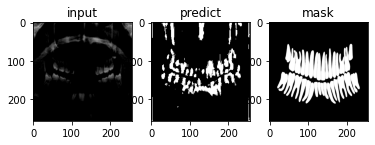

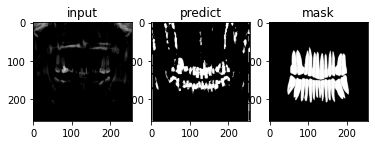

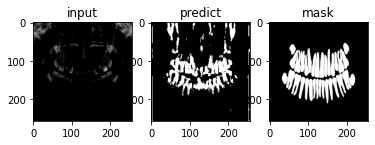

In [ ]:
# test
from thop import profile

args = getArgs()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

temp_dl = torch.FloatTensor(torch.randn(1, 3, 256, 256)).cuda()


# model = UNet_16(3, 1)
# model = NestedUNet(0,in_channel=3,out_channel=1)
model = R2U_Net()
# model = UNet(3,1)


# model.load_state_dict(torch.load(r'./saved_model/'+'_'+str(args.batch_size)+'_'+str(args.epoch)+'.pth', map_location='cpu'))
model.load_state_dict(torch.load(r'/content/drive/MyDrive/r2unet_pth/'+ str(args.weight_name)+'.pth', map_location='cpu'))



model.cuda()

flops, params = profile(model, inputs=(temp_dl, ), verbose=False)


logging.info("=" * 100 + "\nnetwork's flops is: {}, parameters count is: {}, params are:".format(flops, params))

test(val_loader, save_predict=True)